## The Goal: Look at model biases in latent and sensible heat fluxes. Do these line up with regions of high wind variance relative to speed?



<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 28 Aug 2020<br><br>

<b>Short description:</b> Part of the reason we're interested in knowing where the variance of winds might be large is because that could influence latent and sensible heat fluxes. Is that something that's going on in some of these regions/seasons?
<br>

In [66]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle


## Read in data

In [5]:
# Observations 
obsFile = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/processed_LHFLX_RegriddedObs.nc'
LHobsDF = xr.open_dataset(obsFile)
LHobs   = LHobsDF.LH_obs


<b> DUDE. </b> I forgot about how handy sshfs can be (i.e., use osxfuse to mount remote directory to access on local computer without needing to store all the files on it). So for this code, run: <br>
sshfs -o allow_root mdfowler@casper.ucar.edu:/glade/work/mdfowler/data/CLUBB_sim gp_fuse <br>
From home directory (cd ~)

In [111]:
# Model data 
remoteDir = '/Users/meganfowler/gp_fuse/'

nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_flux = '_sfcFluxes.nc'
decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [8]:
# Read in example file to get some constant fields
testName = remoteDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [10]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
#     fileName = remoteDir+nameStart+decadeList[iDec]+nameEnd
#     dataDF   = xr.open_dataset(fileName, decode_times=True)
#     dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

#     UVfile = remoteDir+nameStart+decadeList[iDec]+nameEnd_UV 
#     windDF = xr.open_dataset(UVfile, decode_times=True)
#     windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
    flxFile = remoteDir+nameStart+decadeList[iDec]+nameEnd_flux
    flxDF   = xr.open_dataset(flxFile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
#     PSfile = remoteDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
#         fullDF = dataDF
#         fullUV = windDF
        fullFlx = flxDF 
#         fullPS = presDF
    else:
#         fullDF = xr.concat([fullDF, dataDF], dim="time")
#         fullUV = xr.concat([fullUV, windDF], dim="time")
        fullFlx = xr.concat([fullFlx, flxDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullFlx['time']))
    

<ipython-input-10-7ea281fcb28c>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()


Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


In [12]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullFlx['time'].values) 


In [87]:
np.shape(LHobs)

(192, 288)

## Compute bias 
A few ways to do this... Do we (1) average over each year, then compare to obs and average all years together for mean bias, or (2) compare to obs by month, then average over all time? <br>
Also, which metric of bias do we use? Just straight-up difference between modeled and observed values? RMSE? 

In [80]:
# Let's separate the LHFLX array into [year, month, lat, lon]

midTime   = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 
nYears    = len(np.unique(midTime.year))     # Get number of years in dataset right now 

LHFLX_sim = np.full([nYears, 12, len(lat), len(lon)], np.nan)   # Define empty array to hold LHFLX 

indTrack = 0        # Tracker to skip to next year... 
for iYr in range(nYears): 
    LHFLX_sim[iYr,:,:,:] = np.asarray(fullFlx.LHFLX)[indTrack:indTrack+12,:,:]

    indTrack             = indTrack+12    # Increment tracker to go to next year 


**Option 1: Let's average each year together, and get difference between annual averages**

In [124]:
# Get annual average of simulated LHFLX
annLHFLX = np.nanmean(LHFLX_sim, axis=1)

# Let's limit ourselves to 1982-2008 to match period of observations 
years = np.unique(midTime.year)
iKeep = np.where((years>=1982) & (years<=2008))[0]

LHFLX_sim_sel = LHFLX_sim[iKeep,:,:,:]
annLHFLX_sel  = annLHFLX[iKeep,:,:]

print('Working with %i years to compare to obs.' % len(iKeep))


Working with 27 years to compare to obs.


In [90]:
# Get difference between model and observations
annBias = np.full([len(iKeep), len(lat), len(lon)], np.nan)

for iYr in range(len(iKeep)):
    annBias[iYr,:,:] = annLHFLX_sel[iYr,:,:] - LHobs

# Average over all 27 years 
annBias_avg = np.nanmean(annBias,axis=0)
    

<ipython-input-90-89f5e9c078f3>:8: RuntimeWarning: Mean of empty slice
  annBias_avg = np.nanmean(annBias,axis=0)


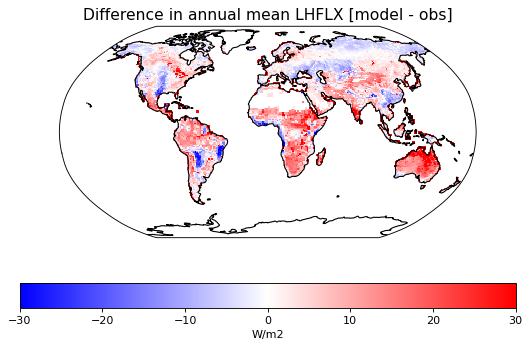

In [96]:
# Plot average bias 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

contour_plot = ax.pcolormesh(lon,lat,annBias_avg,
                             vmin = -30,
                             vmax = 30,
                             cmap = 'bwr',
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='W/m2',orientation='horizontal')
ax.set_title('Difference in annual mean LHFLX [model - obs]', fontsize=14)
plt.show()


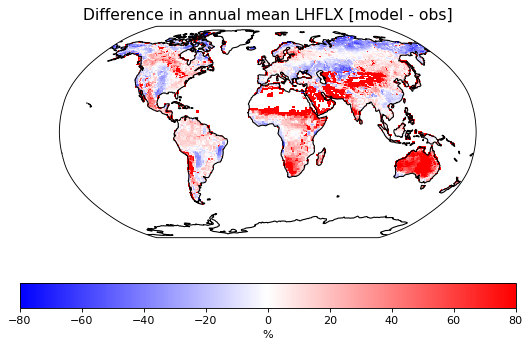

In [106]:
# Plot average bias 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

contour_plot = ax.pcolormesh(lon,lat,(annBias_avg/LHobs)*100,
                             vmin = -80,
                             vmax = 80,
                             cmap = 'bwr',
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='%',orientation='horizontal')
ax.set_title('Difference in annual mean LHFLX [model - obs]', fontsize=14)
plt.show()



In [108]:
# Save the array with residaul S.T. and S.M. z-scores in it 
saveDir  = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
saveFile = 'LH_bias_annAvg_Wm2.p' 

pickle.dump( annBias_avg, open( saveDir+saveFile, "wb" ))
